# TMD A2B for specific eta

In [4]:
pip install -U pysr

Note: you may need to restart the kernel to use updated packages.


Julia and Julia dependencies are installed at first import:

In [6]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [7]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import h5py

# PySR for A12B eta = 8:


In [10]:

file_path = "/Users/hariprashadravikumar/sivers_TMD_PhD_project/save_h5_A12B_A2B/eta_PL_bT_Amp_err_withb0.h5"
#with h5py.File(file_path, "r") as h5_file:
#    # Specify the dataset to extract
#    dataset_name = "Pl-2/eta_8_Pb_bsq_A12B_err"
#    data = np.array(h5_file[dataset_name])

P1 = 1
data_list = []
with h5py.File(file_path, "r") as h5_file:
    dataset_name = f"Pl-{P1}/eta_8_PL_bT_A2B_err" #typo in bL : this is not PL
    dataPl = np.array(h5_file[dataset_name])    
    data_list.append(dataPl)

data = np.vstack(data_list)
# Extract bLbT and A12B
bLbT = data[:, 1:3]  
A2B = data[:, 3]   
A2Berr = data[:, 4]
A2Bweight = [1/sigma**2 for sigma in A2Berr]


#print("bLbT =", bLbT)
#print("A12B =", A12B)
#print("A12Berr =", A12Berr)

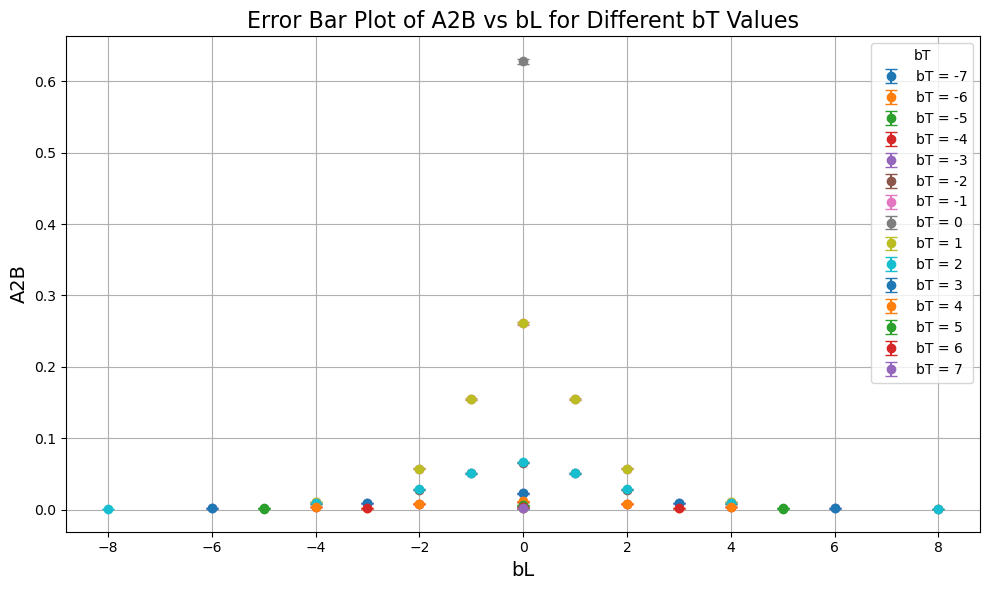

In [12]:

# Extract unique bT values
unique_bT = np.unique(bLbT[:, 1])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bT in enumerate(unique_bT):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 1] == bT
    bL_values = bLbT[mask, 0]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bL_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"bT = {int(bT)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("bL", fontsize=14)
plt.ylabel("A2B", fontsize=14)
plt.title("Error Bar Plot of A2B vs bL for Different bT Values", fontsize=16)
plt.legend(title="bT", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


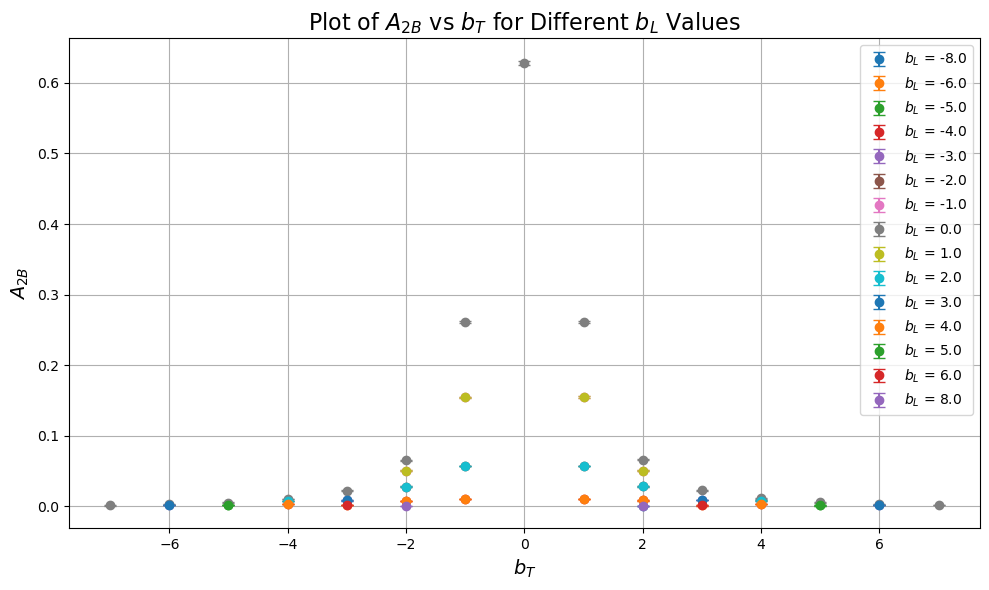

In [14]:
# Extract unique bT values
unique_bL = np.unique(bLbT[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bL in enumerate(unique_bL):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 0] == bL
    bT_values = bLbT[mask, 1]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bT_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$b_L$ = {bL}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b_T$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $b_T$ for Different $b_L$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [32]:
default_pysr_params = dict(
    populations=100,
    model_selection="best",
)

In [ ]:
# test try functions
x = np.linspace(-10, 10, 1000)
y = 1 / (np.sqrt(1+x**2))

#plt.plot(x, y)
#plt.show()

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [34]:
from sympy import exp, symbols, Function

custom_loss_function = """
using Symbolics

function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
    prediction, flag = eval_tree_array(tree, dataset.X, options)
    if !flag
        return L(Inf)
    end
    
    wmse = sum(dataset.weights .* (prediction .- dataset.y) .^ 2) / (dataset.n * sum(dataset.weights))
    return wmse
end
"""

extra_sympy_mappings = {
    "Lorentzian": lambda x, y: 1 / (y + x**2),
    "gaussian": lambda x: exp(-x**2),
    "decay": lambda x: exp(-x)
}

modelold = PySRRegressor(
    niterations=50,
    unary_operators=["gaussian(x) = exp(-x^2)", "decay(x) = exp(-x)"],
    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0, "Lorentzian": 0, "decay": 0},"Lorentzian": {"Lorentzian": 0, "gaussian": 0, "decay": 0},  "decay": {"Lorentzian": 0, "gaussian": 0, "decay": 0}},
    constraints={'gaussian': (-1, 1), 'Lorentzian': (-1, 1), 'decay': (-1, 1)}

)

model = PySRRegressor(
    niterations=100,
    unary_operators=["gaussian(x) = exp(-x^2)"],
    binary_operators=["*"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    #loss_function=custom_loss_function,  # Use the custom loss function
    nested_constraints = { "gaussian": {"gaussian": 0}},
    constraints={'gaussian': (-1, 1)}

)

model.fit(bLbT, A2B, weights=A2Bweight, variable_names=['bL', 'bT'])



/opt/homebrew/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.440e+05
Progress: 950 / 3100 total iterations (30.645%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.507e-04  1.594e+01  y = 0.011491
4           5.014e-04  8.687e-02  y = gaussian(bT * 1.7638)
5           2.893e-04  5.499e-01  y = gaussian(bL) * gaussian(bT)
7           2.292e-04  1.163e-01  y = gaussian(bT) * gaussian(bL * 0.75189)
9           1.350e-04  2.649e-01  y = gaussian(bT) * (gaussian(bL * 0.59419) * 0.6499)
11          5.373e-05  4.605e-01  y = (gaussian(bT * 0.63409) * 0.37073) * gaussian(bL * 0.6...
                                      0087)
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                        0.011491025   
	1        0.086875                           gaussian(bT * 1.7638065)   
	2        0.549936                        gaussian(bL) * gaussian(bT)   
	3        0.116340            gaussian(bT) * gaussian(bL * 0.7518853)   
	4        0.264923  (gaussian(bL * -0.5941109) * 0.6498232) * gaus...   
	5  >>>>  0.460460  (gaussian(bT * 0.63409376) * 0.37073) * gaussi...   
	6        0.000017  (gaussian(bT * -0.6355339) * (gaussian(bL * -0...   
	
	       loss  complexity  
	0  0.000651           1  
	1  0.000501           4  
	2  0.000289           5  
	3  0.000229           7  
	4  0.000135           9  
	5  0.000054          11  
	6  0.000054          16  
]

  - outputs/20250315_152629_zYMDAL/hall_of_fame.csv


We can print the model, which will print out all the discovered expressions:

We can also view the SymPy format of the best expression:

In [44]:
model.sympy(3)

exp(-0.56533150435609*bL**2)*exp(-bT**2)

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

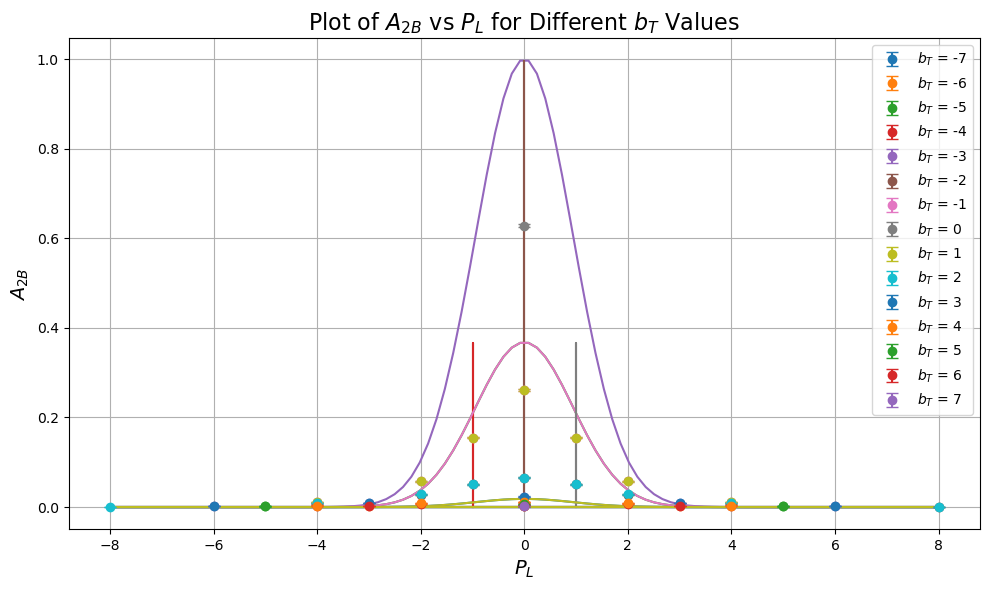

exp(-0.56533150435609*bL**2)*exp(-bT**2)

In [46]:
pick = 3


bL_plot = np.linspace(-8,8, 100)
plt.figure(figsize=(10, 6))

for bT in unique_bT:
    bLbT_plot = np.array([[bL, bT] for bL in bL_plot])
    predictions = model.predict(bLbT_plot, pick)
    plt.plot(bLbT_plot, predictions)
for i, bT in enumerate(unique_bT):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 1] == bT
    bL_values = bLbT[mask, 0]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bL_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$b_T$ = {int(bT)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$P_{L}$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $P_L$ for Different $b_T$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()



model.sympy(pick)

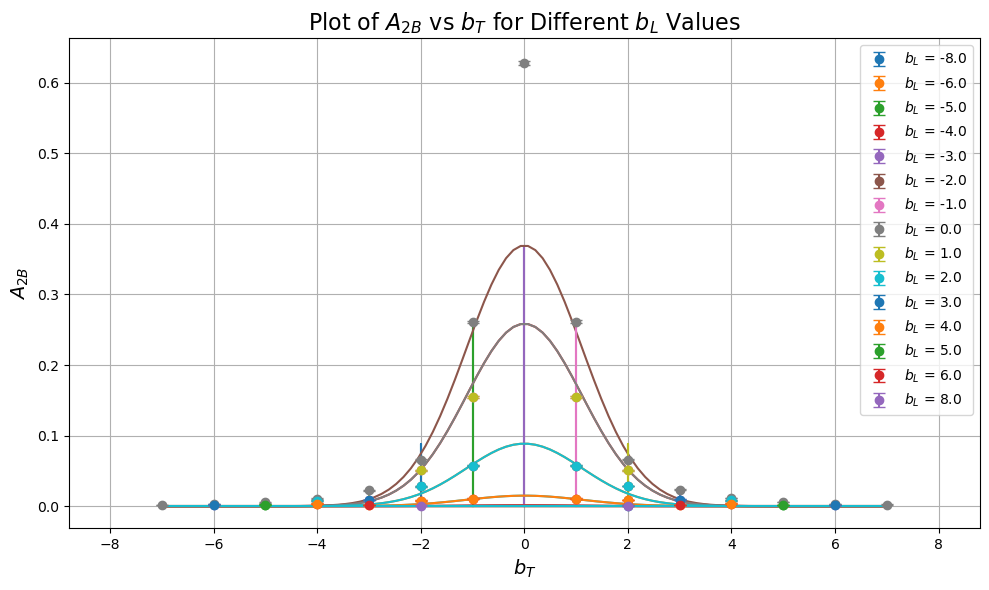

exp(-0.35696370926736*bL**2)*exp(-0.40205009110564*bT**2)*0.36951917

In [28]:

bT_plot = np.linspace(-7,7, 100)
plt.figure(figsize=(10, 6))

for bL in unique_bL:
    bLbT_plott = np.array([[bL, bT] for bT in bT_plot])
    predictions = model.predict(bLbT_plott, pick)
    plt.plot(bLbT_plott, predictions)

for i, bL in enumerate(unique_bL):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = bLbT[:, 0] == bL
    bT_values = bLbT[mask, 1]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        bT_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$b_L$ = {bL}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b_T$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $b_T$ for Different $b_L$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

model.sympy(pick)


In [ ]:
model.equations_[["complexity", "loss", "equation"]]